# Single Spectrum Analysis

Illustration de la méthode [SSA](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) pour les séries temporelles.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Une série articielle

In [3]:
import numpy.random as rnd
import numpy
N = 2000
bruit1 = rnd.normal(size=(N,))
bruit2 = rnd.normal(size=(N,))
bruit3 = rnd.normal(size=(N,))
temps = numpy.arange(N)
bruit1[:5], temps[:5]

(array([ 0.69014231,  0.9733566 , -0.05037825, -1.66630364, -2.19906331]),
 array([0, 1, 2, 3, 4]))

In [4]:
serie = []
y = 2
for i in range(N//2+100):
    serie.append(y + bruit1[i] + 0.0002 * temps[i])
    if i > 30:
        y = 0.5 * y + 0.4 * serie[-7] + 0.1 * serie[-30]
Y = numpy.array(serie[-1000:])
Y[:5]

array([1.64801411, 2.85366468, 1.73253876, 2.17645817, 1.34021498])

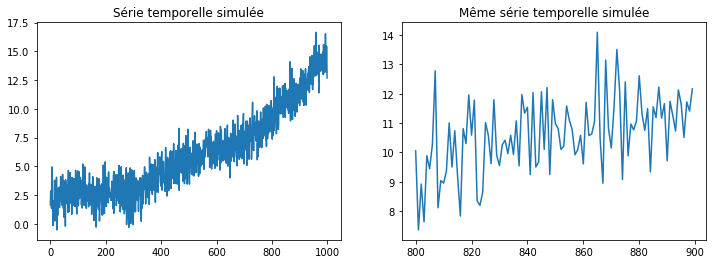

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(numpy.arange(len(Y)), Y)
ax[1].plot(numpy.arange(800, 900), Y[800:900])
ax[0].set_title("Série temporelle simulée")
ax[1].set_title("Même série temporelle simulée");

## Autocorrélation

In [6]:
from pandas import DataFrame
df = DataFrame(dict(Y=Y))
df.head()

,Y
0,1.648014
1,2.853665
2,1.732539
3,2.176458
4,1.340215


In [7]:
from statsmodels.tsa.tsatools import detrend
df["notrend"] = detrend(df.Y)
df.head()

,Y,notrend
0,1.648014,1.418843
1,2.853665,2.612794
2,1.732539,1.479968
3,2.176458,1.912187
4,1.340215,1.064244


Text(0.5, 1.0, 'Sans tendance')

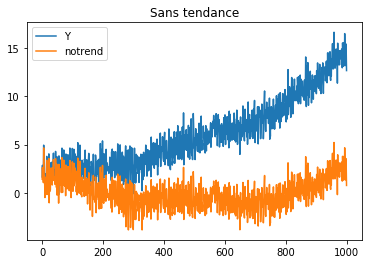

In [8]:
ax = df.plot()
ax.set_title("Sans tendance")

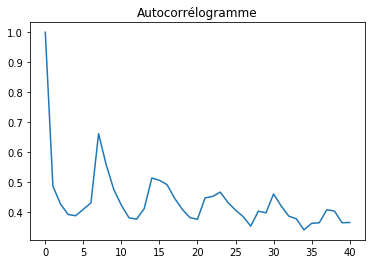

In [9]:
from statsmodels.tsa.stattools import acf
cor = acf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(cor)
ax.set_title("Autocorrélogramme");

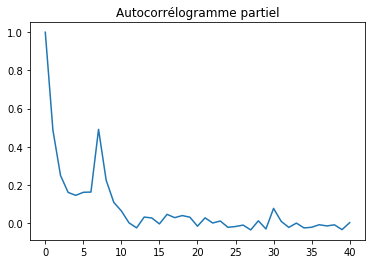

In [10]:
from statsmodels.tsa.stattools import pacf
pcor = pacf(df.notrend)
fig, ax = plt.subplots(1, 1)
ax.plot(pcor)
ax.set_title("Autocorrélogramme partiel");

## SSA

In [11]:
def lagged_ts(serie, lag):
    dim = serie.shape[0]
    res = numpy.zeros((dim - lag + 1, lag))
    for i in range(lag):
        res[:, i] = serie[i:dim-lag+i+1]
    return res

lagged_ts(Y, 3)

array([[ 1.64801411,  2.85366468,  1.73253876],
       [ 2.85366468,  1.73253876,  2.17645817],
       [ 1.73253876,  2.17645817,  1.34021498],
       ...,
       [13.20541312, 14.53735339, 15.44861443],
       [14.53735339, 15.44861443, 14.57147571],
       [15.44861443, 14.57147571, 12.68411161]])

In [12]:
lag = lagged_ts(Y, 60)
lag.shape

(941, 60)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca.fit(lag)

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

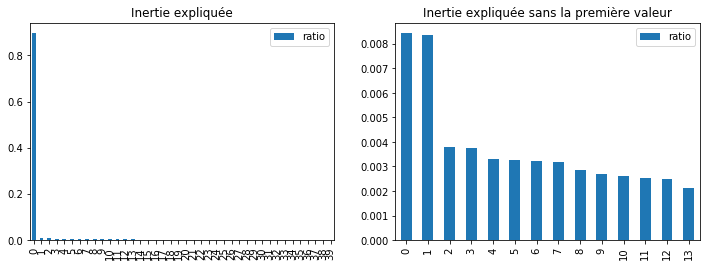

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
DataFrame(dict(ratio=pca.explained_variance_ratio_)).plot(kind="bar", ax=ax[0])
DataFrame(dict(ratio=pca.explained_variance_ratio_[1:15])).plot(kind="bar", ax=ax[1])
ax[0].set_title("Inertie expliquée")
ax[1].set_title("Inertie expliquée sans la première valeur");

In [15]:
pca.components_.shape, lag.shape

((40, 60), (941, 60))

In [16]:
X2 = lag @ pca.components_.T
X2.shape

(941, 40)

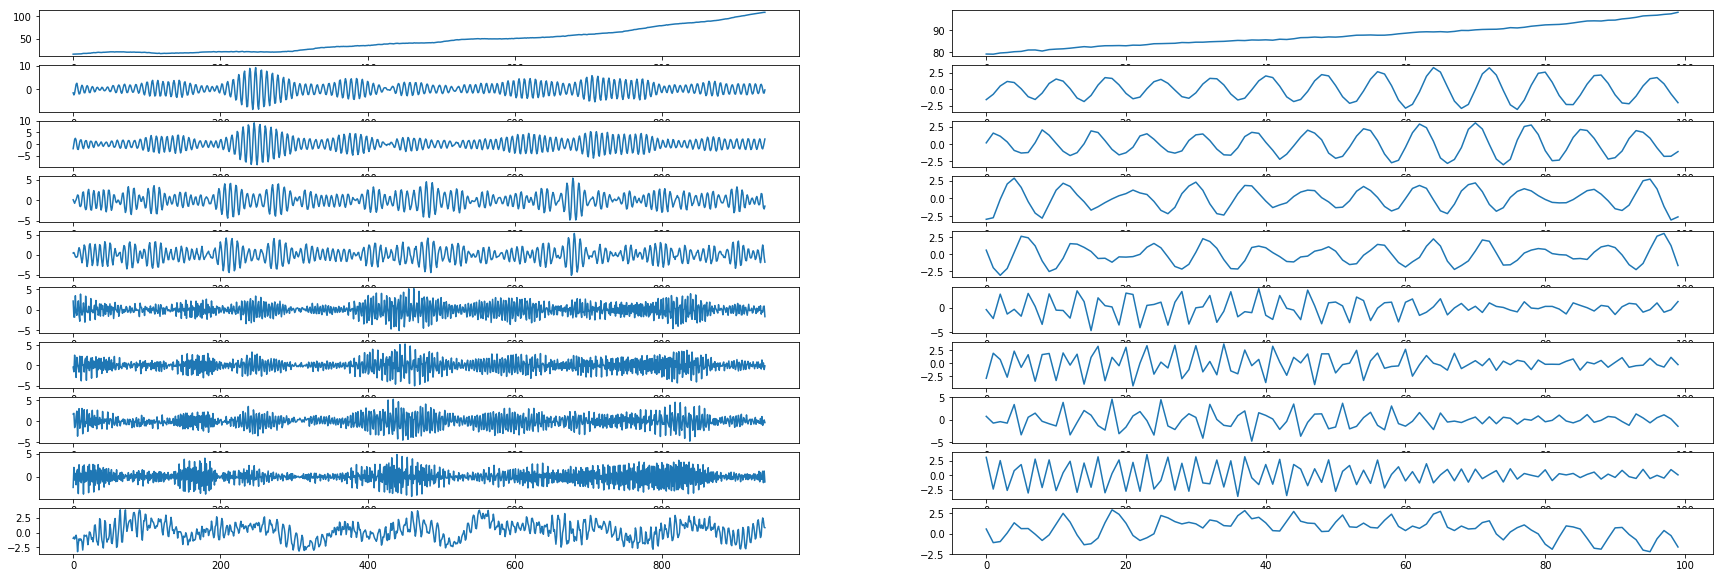

In [17]:
np = 10
fig, ax = plt.subplots(np, 2, figsize=(np*3, 10))
for i in range(np):
    ax[i, 0].plot(X2[:,i])
    ax[i, 1].plot(X2[800:900,i])